In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle competitions download -c quora-question-pairs

 99% 305M/309M [00:02<00:00, 128MB/s]
100% 309M/309M [00:02<00:00, 139MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/quora-question-pairs.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/train.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('train.csv')

In [17]:
new_df = df.sample(30000, random_state=2)

In [18]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [19]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [20]:
new_df.duplicated().sum()

0

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 398782 to 312470
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


In [22]:
str(new_df.iloc[0]['question1']).lower().strip()

'what is the best marketing automation tool for small and mid-size companies?'

In [23]:
def preprocess(q):
  q = str(q).lower().strip()

  # Replace certain special characters with their string equivalents
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')

  # The pattern '[math]' appears around 900 times in the whole dataset.
  q = q.replace('[math]', '')

  # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
  q = q.replace(',000,000,000 ', 'b ')
  q = q.replace(',000,000 ', 'm ')
  q = q.replace(',000 ', 'k ')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)

  # Decontracting words
  contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "can not",
  "can't've": "can not have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
  }

  q_decontracted = []

  for word in q.split():
    if word in contractions:
      word = contractions[word]

    q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  #Removing HTML tags
  q = BeautifulSoup(q);
  q = q.get_text()

  #Remove punctuations
  pattern = re.compile('\W')
  q = re.sub(pattern,' ',q).strip()

  return q;


In [24]:
preprocess("Really! No I don't agree with you, you can't have 10000000 rupees")

'really  no i do not agree with you  you can not have 10m rupees'

In [25]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [26]:
new_df.shape

(30000, 6)

In [27]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [28]:
new_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [29]:
#Apply stemming
import nltk
from nltk.stem import SnowballStemmer
from tqdm import tqdm

In [30]:
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([(stemmer.stem(word.strip())).strip() for word in text.split()])

In [31]:
stem_words("Really! No I don't agree with you, you can't have 10000000 rupees, i was dancing and singing with her!")

"really! no i don't agre with you, you can't have 10000000 rupees, i was danc and sing with her!"

In [32]:
pbar = tqdm(total=len(df), desc='Stemming question1')
new_df['question1'] = new_df['question1'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

Stemming question1:   7%|▋         | 30000/404290 [00:03<00:45, 8196.13it/s]


In [33]:
pbar = tqdm(total=len(df), desc='Stemming question1')
new_df['question2'] = new_df['question2'].apply(lambda x: (pbar.update(1), stem_words(x))[1])
pbar.close()

Stemming question1:   7%|▋         | 30000/404290 [00:05<01:03, 5920.49it/s]


In [34]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...,0
367788,367788,498109,491396,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...,0
151235,151235,237843,50930,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi,0


In [35]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [36]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

In [37]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [38]:
new_df['word_common'] = new_df.apply(common_words, axis=1)

In [39]:
def total_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return (len(w1) + len(w2))

In [40]:
new_df['word_total'] = new_df.apply(total_words, axis=1)

In [41]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)

In [42]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,65,65,13,13,13,26,0.50
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,47,54,12,15,7,22,0.32
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...,0,101,103,26,20,3,36,0.08
367788,367788,498109,491396,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...,0,55,135,13,30,0,32,0.00
151235,151235,237843,50930,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi,0,29,49,5,9,3,13,0.23


In [43]:
#Advanced Features
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [44]:
def fetch_token_features(row):
  q1 = row['question1']
  q2 = row['question2']

  SAFE_DIV = 0.0001;

  STOP_WORDS = stopwords.words("english")

  token_features = [0.0]*8

  #Converting the sequence into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  #Get the stopwords in Questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  # Get the common non-stopwords from Question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

  # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

  # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])

  return token_features

In [45]:
token_features = new_df.apply(fetch_token_features, axis=1)

In [46]:
new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [47]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,65,65,13,13,...,26,0.50,0.999988,0.999988,0.999980,0.999980,0.999992,0.999992,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,47,54,12,15,...,22,0.32,0.666644,0.399992,0.714276,0.714276,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...,0,101,103,26,20,...,36,0.08,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...,0,55,135,13,30,...,32,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi,0,29,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [48]:
!pip install distance

In [49]:
import distance
#Length based features
def fetch_length_features(row):
  q1 = row['question1']
  q2 = row['question2']

  length_features = [0.0]*3

  #Converting the sentences into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if(len(q1_tokens)==0 or len(q2_tokens)==0):
    return length_features

  #Absolute Length features
  length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

  #Average Token Length of both Questions
  length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

  #Longest substring ratio
  strs = list(distance.lcsubstrings(q1, q2))
  length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

  return length_features

In [50]:
length_features = new_df.apply(fetch_length_features, axis=1)

In [51]:
new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [52]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,65,65,13,13,...,0.999988,0.999980,0.999980,0.999992,0.999992,1.0,1.0,0.0,13.0,0.984848
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,47,54,12,15,...,0.399992,0.714276,0.714276,0.583328,0.466664,1.0,1.0,3.0,13.5,0.229167
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...,0,101,103,26,20,...,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,0.049020
367788,367788,498109,491396,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...,0,55,135,13,30,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.053571
151235,151235,237843,50930,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi,0,29,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.633333


In [53]:
#Fuzzy features
!pip install fuzzywuzzy

In [54]:
from fuzzywuzzy import fuzz

In [55]:
def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [56]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [57]:
len(list(map(lambda x: x[0], fuzzy_features)))

30000

In [58]:
print(new_df.shape)
new_df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,65,65,13,13,...,0.999992,1.0,1.0,0.0,13.0,0.984848,100,100,100,100
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,47,54,12,15,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,68,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...,0,101,103,26,20,...,0.115384,0.0,0.0,6.0,23.0,0.049020,29,32,28,39
367788,367788,498109,491396,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...,0,55,135,13,30,...,0.000000,0.0,0.0,17.0,21.5,0.053571,27,45,17,17
151235,151235,237843,50930,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi,0,29,49,5,9,...,0.333330,1.0,0.0,4.0,7.0,0.633333,59,72,51,77


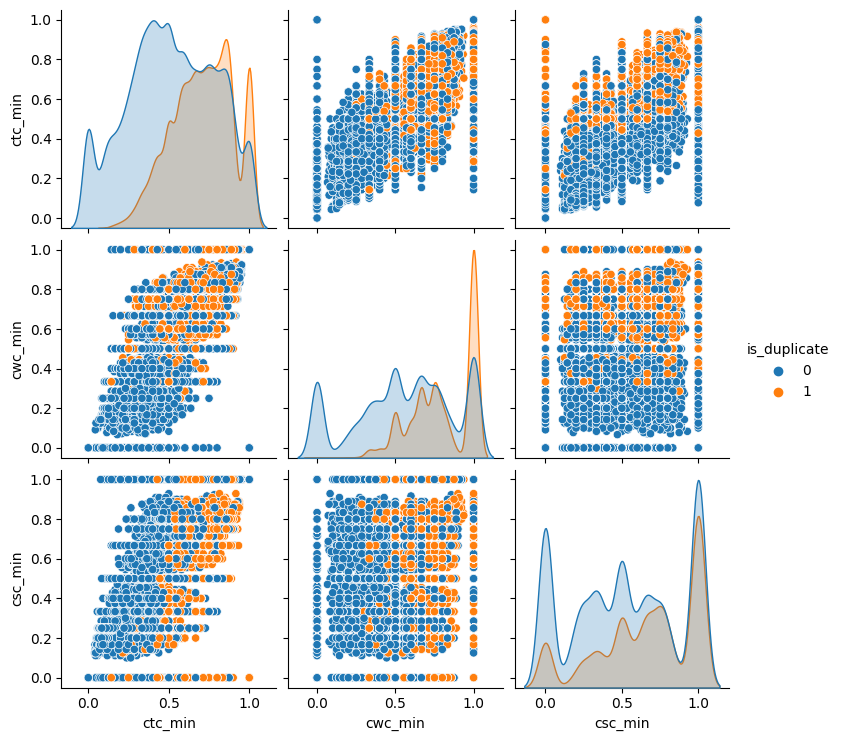

In [ ]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

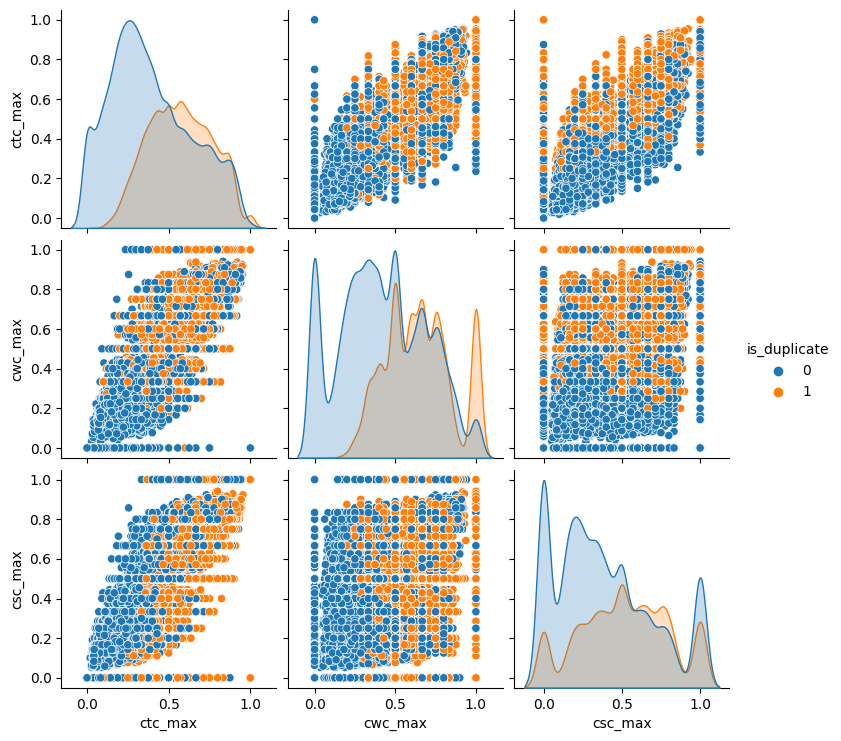

In [ ]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 398782 to 235133
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    40000 non-null  int64  
 1   qid1                  40000 non-null  int64  
 2   qid2                  40000 non-null  int64  
 3   question1             40000 non-null  object 
 4   question2             40000 non-null  object 
 5   is_duplicate          40000 non-null  int64  
 6   q1_len                40000 non-null  int64  
 7   q2_len                40000 non-null  int64  
 8   q1_num_words          40000 non-null  int64  
 9   q2_num_words          40000 non-null  int64  
 10  word_common           40000 non-null  int64  
 11  word_total            40000 non-null  int64  
 12  word_share            40000 non-null  float64
 13  cwc_min               40000 non-null  float64
 14  cwc_max               40000 non-null  float64
 15  csc_min      

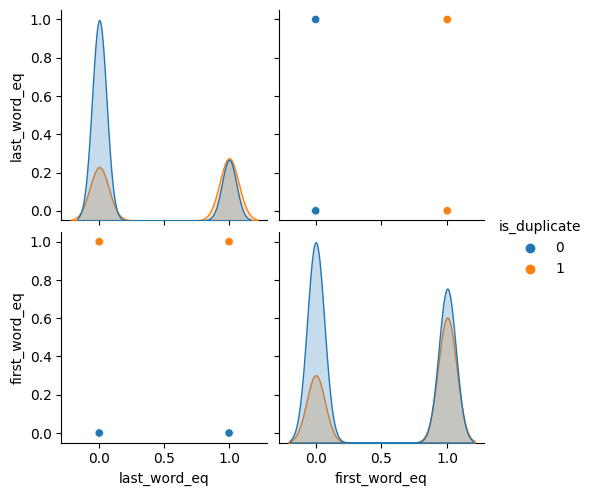

In [ ]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

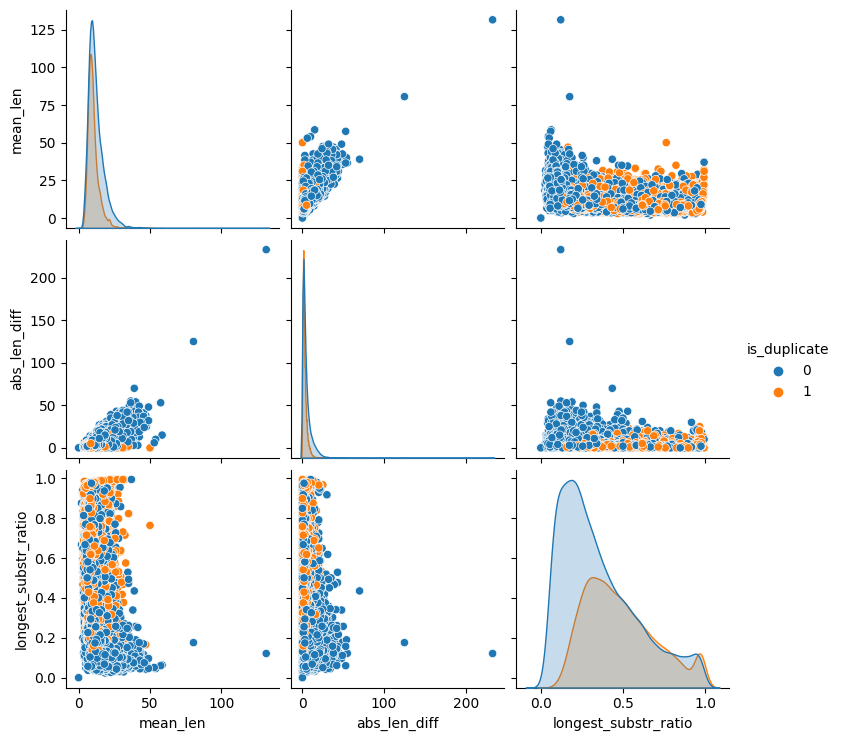

In [ ]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')


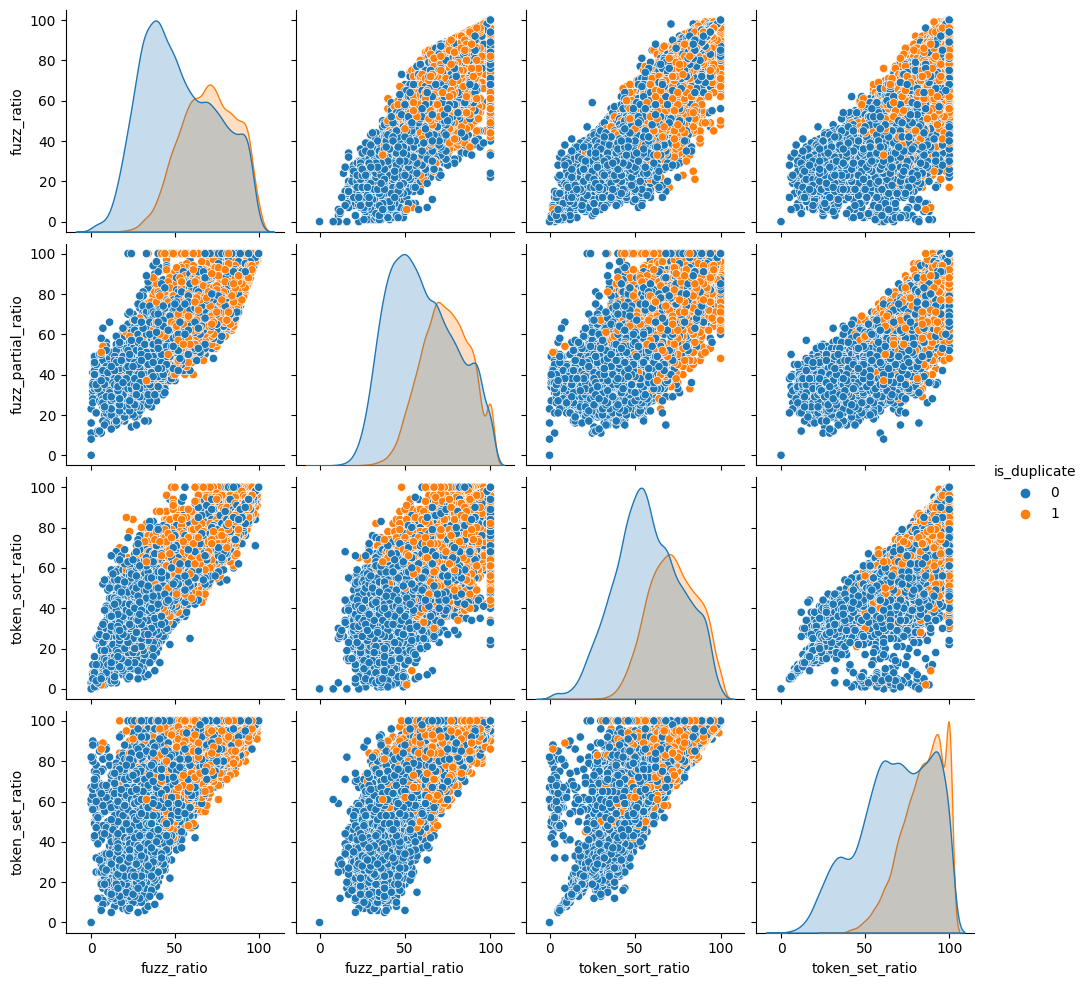

In [ ]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')


In [49]:
new_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,65,65,13,13,...,0.999992,1.0,1.0,0.0,13.0,0.984848,100,100,100,100
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,47,54,12,15,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,68,65,74


In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [ ]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method = "barnes_hut",
    n_iter = 1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.150s...
[t-SNE] Computed neighbors for 40000 samples in 14.590s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sa

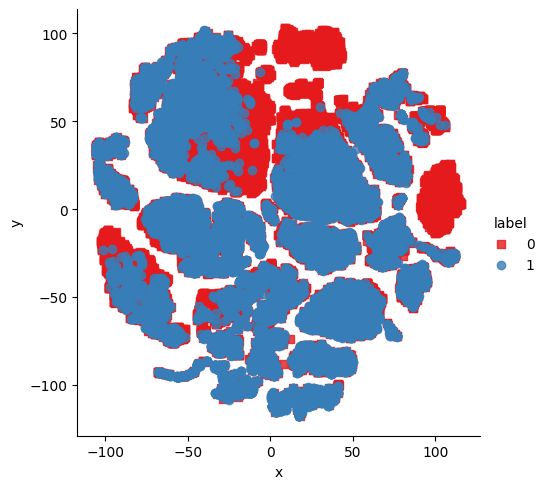

In [ ]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

In [ ]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [59]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best market autom tool for small a...,what is the best market autom tool for small a...
115086,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...
327711,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...
367788,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...
151235,consequ of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi


In [60]:
final_df = new_df.drop(columns = ['id','qid1', 'qid2', 'question1', 'question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,65,65,13,13,13,26,0.50,0.999988,0.999988,...,0.999992,1.0,1.0,0.0,13.0,0.984848,100,100,100,100
115086,0,47,54,12,15,7,22,0.32,0.666644,0.399992,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,68,65,74
327711,0,101,103,26,20,3,36,0.08,0.000000,0.000000,...,0.115384,0.0,0.0,6.0,23.0,0.049020,29,32,28,39
367788,0,55,135,13,30,0,32,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,17.0,21.5,0.053571,27,45,17,17
151235,0,29,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1.0,0.0,4.0,7.0,0.633333,59,72,51,77


In [61]:
final_df

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,65,65,13,13,13,26,0.50,0.999988,0.999988,...,0.999992,1.0,1.0,0.0,13.0,0.984848,100,100,100,100
115086,0,47,54,12,15,7,22,0.32,0.666644,0.399992,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,68,65,74
327711,0,101,103,26,20,3,36,0.08,0.000000,0.000000,...,0.115384,0.0,0.0,6.0,23.0,0.049020,29,32,28,39
367788,0,55,135,13,30,0,32,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,17.0,21.5,0.053571,27,45,17,17
151235,0,29,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1.0,0.0,4.0,7.0,0.633333,59,72,51,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,1,36,37,7,7,6,14,0.43,0.749981,0.749981,...,0.857131,0.0,1.0,0.0,7.0,0.810811,88,89,79,89
91980,0,61,54,12,13,4,25,0.16,0.499992,0.428565,...,0.307690,0.0,0.0,1.0,12.5,0.272727,56,60,49,54
266955,0,66,88,14,17,6,30,0.20,0.499994,0.499994,...,0.352939,0.0,0.0,3.0,15.5,0.134328,27,30,56,66
71112,1,49,43,10,10,7,20,0.35,0.999975,0.799984,...,0.699993,1.0,1.0,0.0,10.0,0.386364,72,65,72,84


In [62]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3200)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [63]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6400)

In [64]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6423)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199
398782,1,65,65,13,13,13,26,0.50,0.999988,0.999988,...,0,0,0,0,0,0,0,0,0,0
115086,0,47,54,12,15,7,22,0.32,0.666644,0.399992,...,0,0,0,0,0,0,0,0,0,0
327711,0,101,103,26,20,3,36,0.08,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,55,135,13,30,0,32,0.00,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
151235,0,29,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [65]:
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7851428571428571

In [73]:
precision_score(y_test,y_pred)

0.7373211963589077

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

In [ ]:
precision_score(y_test,y_pred1)

In [60]:
from sklearn.linear_model import LogisticRegression
modelLogistic = LogisticRegression()
modelLogistic.fit(X_train, y_train)
y_pred2 = modelLogistic.predict(X_test)
accuracy_score(y_test,y_pred2)

0.7328333333333333

In [61]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred3 = dt.predict(X_test)
accuracy_score(y_test,y_pred3)

0.7243333333333334

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred4 = knc.predict(X_test)
accuracy_score(y_test,y_pred4)

0.6966666666666667

In [68]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
etc.fit(X_train, y_train)
y_pred5 = etc.predict(X_test)


In [69]:
accuracy_score(y_test,y_pred5)


0.795

In [70]:
precision_score(y_test,y_pred5)

0.760601180891036

In [71]:
confusion_matrix(y_test,y_pred5)

array([[3353,  446],
       [ 784, 1417]])

In [67]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
abc.fit(X_train, y_train)
y_pred6 = abc.predict(X_test)
accuracy_score(y_test,y_pred6)

0.752

In [69]:
from xgboost import XGBClassifier

In [70]:
#Apply voting
# Voting Classifier
xgb = XGBClassifier(n_estimators=100,random_state=2)
etc = ExtraTreesClassifier(n_estimators=100, random_state=2)
rfc = RandomForestClassifier(n_estimators=100, random_state=2)


from sklearn.ensemble import VotingClassifier

In [71]:
voting = VotingClassifier(estimators=[('xgb',xgb), ('et',etc), ('rf',rfc)], voting='soft')

In [ ]:
voting.fit(X_train, y_train)

In [81]:
y_pred  =voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.7963333333333333
Precision 0.7448724362181091


In [78]:
etc

ExtraTreesClassifier(random_state=2)

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [ ]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3290,  509],
       [ 761, 1440]])

In [ ]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3224,  575],
       [ 694, 1507]])

In [ ]:
# for LR
confusion_matrix(y_test,y_pred2)

array([[3224,  575],
       [ 694, 1507]])

In [ ]:
# for DT
confusion_matrix(y_test,y_pred3)

array([[3224,  575],
       [ 694, 1507]])

In [ ]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)

In [ ]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return (len(w1) + len(w2))

In [ ]:
def test_fetch_token_features(q1,q2):

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [ ]:
def test_fetch_length_features(q1,q2):

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [ ]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
def query_point_creator(q1,q2):

    input_query = []

    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))

    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)

    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()

    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()



    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'Who is the founder of Google?'
q5 = 'Who is the founder of the company google?'

In [ ]:
nth=561
q1 = df.iloc[nth]['question1']
q2 = df.iloc[nth]['question2']
df.iloc[nth]['is_duplicate']

1

In [ ]:
print(q1)
print(q2)

What can be the medium budget to visit best places in Kerala for three members (2-3 days)?
What are the best places to visit in Kerala for college students?


In [ ]:
rf.predict(query_point_creator(q4,q5))

array([1])

In [ ]:
rf

RandomForestClassifier()

In [ ]:
cv

CountVectorizer(max_features=3000)

In [ ]:
stopwords

<WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>

In [76]:
import pickle

# pickle.dump(etc,open('model8.pkl','wb'))
pickle.dump(cv,open('cv2.pkl','wb'))
# pickle.dump(stopwords,open('stopwords.pkl','wb'))

In [66]:
etc

ExtraTreesClassifier(random_state=2)

In [72]:
import bz2
import pickle

In [73]:
pickle.dump(etc,bz2.BZ2File('model7.pkl','wb'))